# Fine Tuning DETR on Thermal Dogs and People Dataset

## Load roboflow dataset

In [ ]:
#mount drive
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive

/
Mounted at /content/gdrive


In [2]:
!pip -q install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ajQH8UoXUQhfS19128Xd")
project = rf.workspace("joseph-nelson").project("thermal-dogs-and-people")
dataset = project.version(1).download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Thermal-Dogs-and-People-1 in coco:: 100%|██████████| 208/208 [00:00<00:00, 6874.88it/s]


In [ ]:
%cd /content

/content


In [4]:
!pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 104.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.5 MB/s eta 0:00:00


In [5]:
!pip install -q pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.7 MB/s eta 0:00:00


In [2]:
#@title upload your .env file before runnning this cell
import os
from dotenv import load_dotenv

dotenv_path = '/content/.env'
load_dotenv(dotenv_path)
KEY = os.environ.get("WANDB_API_KEY")

In [4]:
# Log to wandb
!pip install -q wandb

In [5]:
import wandb
wandb.login(key=KEY)

wandb: Currently logged in as: faldeus0092. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## DETR
https://github.com/facebookresearch/detr/tree/main A transformer based object detection

### Create PyTorch Datasets
I follow guide from this https://github.com/NielsRogge/Transformers-Tutorials/tree/master , Huge thanks for Niels Rogge

In [1]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = os.path.join(img_folder, "_annotations.coco.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

### Create train and val from datasets prepared before, using HF's feature extractor

In [33]:
from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder='/content/Thermal-Dogs-and-People-1/train', processor=processor)
val_dataset = CocoDetection(img_folder='/content/Thermal-Dogs-and-People-1/valid', processor=processor, train=False)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### Double check number of examples

In [7]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 142
Number of validation examples: 41


### Sanity check by visualizing the dataset

Image n°125


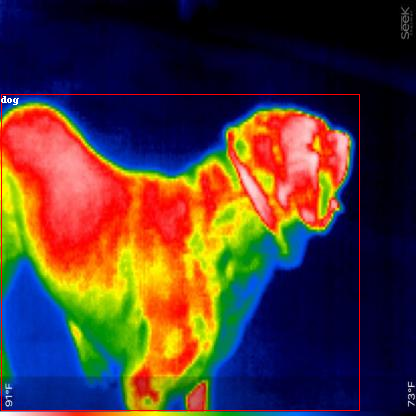

In [8]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('/content/Thermal-Dogs-and-People-1/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

### Create DataLoader
custom collate function created to pad the image to highest value according to biggest image in the batch

In [9]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

In [10]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [11]:
pixel_values, target = train_dataset[0]

### Define the model

In [34]:
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch

class Detr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         # we specify the "no_timm" variant here to not rely on the timm library
         # for the convolutional backbone
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm",
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [32]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
outputs.logits.shape

torch.Size([1, 100, 4])

In [36]:
train_dataset.coco.cats

{0: {'id': 0, 'name': 'dogs-person', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'dog', 'supercategory': 'dogs-person'},
 2: {'id': 2, 'name': 'person', 'supercategory': 'dogs-person'}}

### Initialize Wandb logger

In [30]:
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(log_model="all", project="thermal-dogs-and-people", name="run2-main")

### Train

In [37]:
from pytorch_lightning import Trainer

trainer = Trainer(accelerator='gpu', max_epochs=100, gradient_clip_val=0.1, logger=wandb_logger)
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
18.0 M    Trainable params
23.5 M    Non-trainable params
41.5 M    Total params
166.009   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [19]:
wandb.finish()

epoch,▁▃▃▅▅▆██
train_cardinality_error,▅█▁
train_loss_bbox,▁█▆
train_loss_ce,██▁
train_loss_giou,▁▃█
trainer/global_step,▁▂▃▄▅▆▇█
training_loss,▁██
validation_cardinality_error,▅▅▁▃█
validation_loss,█▅▃▂▁
validation_loss_bbox,█▅▃▃▁
validation_loss_ce,█▅▃▁▁


In [38]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_cardinality_error,▂▂▃▆█▂▂▁▁▁▂▂▂▁▂▂▃▃▂▁▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁
train_loss_bbox,█▅▄▃▄▆▄▅▂▁▄▃▃▄▂▂▂▁▂▅▃▂▅▃▃▃▄▁▂▂▁▄▁▁▂▃▄▁▂▄
train_loss_ce,█▇▇█▇▅▂▂▂▂▂▁▂▁▁▂▂▂▂▁▁▂▁▂▁▁▂▂▁▁▁▁▃▁▁▁▁▁▁▁
train_loss_giou,▅▄▃▆▆▇▃▄▃▂█▂▃▅▂▅█▄▃▄▅▆▂▇▂▄▅▃▅▁▆▄▄▃▃▃▄▃▄▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_loss,█▆▆▇▇▇▃▄▂▂▆▂▂▄▂▃▅▃▃▄▄▄▃▄▂▃▄▂▃▁▄▃▃▂▂▂▃▂▂▂
validation_cardinality_error,▄▄▅▆█▂▂▂▂▂▂▂▁▂▁▁▂▂▂▂▁▁▅▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁
validation_loss,██▅▅▅▃▃▂▂▂▃▃▂▂▁▃▂▂▂▃▁▃▃▂▃▄▃▂▃▂▂▁▂▂▂▄▂▂▃▃
validation_loss_bbox,█▇▃▅▇▃▃▂▃▃▃▃▃▂▁▂▂▂▃▄▁▃▄▃▄▆▃▂▃▂▂▂▂▂▂▅▂▂▃▄
validation_loss_ce,█▇▅▅▄▂▂▂▂▁▁▂▁▂▁▂▁▂▁▁▂▂▂▁▁▁▁▁▁▂▁▁▁▂▂▁▂▁▂▁


### Eval

In [ ]:
!pip install huggingface_hub

In [20]:
# Log into Hugging Face's platform

# Put your code here:
from huggingface_hub import notebook_login

notebook_login()
# ---- End of your code ----

In [39]:
model.model.push_to_hub("faldeus0092/detr-finetuned-thermal-dogs-and-people")
processor.push_to_hub("faldeus0092/detr-finetuned-thermal-dogs-and-people")

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/faldeus0092/detr-finetuned-thermal-dogs-and-people/commit/5800931f48a93c02c5aa8cd817594c64b3e1c931', commit_message='Upload processor', commit_description='', oid='5800931f48a93c02c5aa8cd817594c64b3e1c931', pr_url=None, pr_revision=None, pr_num=None)

In [23]:
id2label = {
    0: "dogs-person",
    1: "dog",
    2: "person",
}
id2label[2]

'person'

In [40]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch

model = DetrForObjectDetection.from_pretrained("faldeus0092/detr-finetuned-thermal-dogs-and-people", id2label=id2label)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
processor = DetrImageProcessor.from_pretrained("faldeus0092/detr-finetuned-thermal-dogs-and-people")

In [26]:
!pip install -q coco-eval

  Preparing metadata (setup.py) ... done


In [27]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [28]:
val_dataloader

In [29]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

    # provide to metric
    # metric expects a list of dictionaries, each item
    # containing image_id, category_id, bbox and score keys
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)


evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/21 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.17s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.476
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.645
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.557
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.168
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.482
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.562
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.659
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.661
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.272
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [41]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

    # provide to metric
    # metric expects a list of dictionaries, each item
    # containing image_id, category_id, bbox and score keys
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)


evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/21 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.681
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.870
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.641
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.733
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.746
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.542
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [83]:
map = 0.720
recall = 0.794
print(f"f1 score IoU=0.50:0.95 area= large:{2*map*recall/(map+recall)}")

f1 score IoU=0.50:0.95 area= large:0.7551915455746366


### Inference


In [42]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [43]:
#We can use the image_id in target to know which image it is
test_dataset = CocoDetection(img_folder='/content/Thermal-Dogs-and-People-1/test', processor=processor, train=False)
pixel_values, target = test_dataset[1]

pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

with torch.no_grad():
  # forward pass to get class logits and bounding boxes
  outputs = model(pixel_values=pixel_values, pixel_mask=None)
print("Outputs:", outputs.keys())

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
torch.Size([1, 3, 800, 800])
Outputs: odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


In [85]:
test_dataset.coco.loadImgs(1)[0]

{'id': 1,
 'license': 1,
 'file_name': 'IMG_0006 5_jpg.rf.cd46e6a862d6ffb7fce6795067ce7cc7.jpg',
 'height': 416,
 'width': 416,
 'date_captured': '2020-05-25T00:08:21+00:00'}

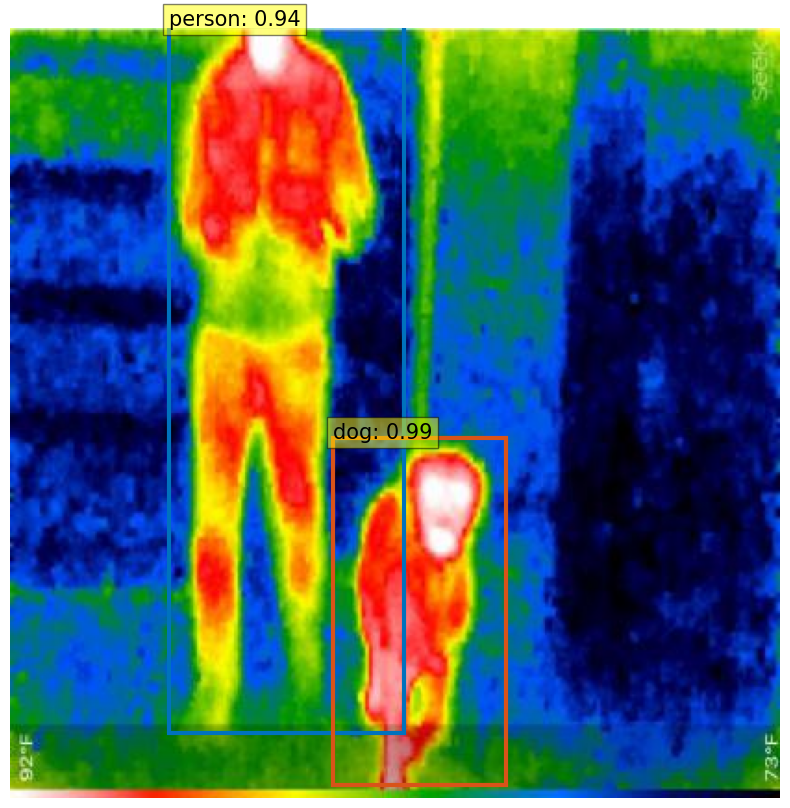

In [46]:
# load image based on ID
image_id = target['image_id'].item()
image = test_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('/content/Thermal-Dogs-and-People-1/test', image['file_name']))

# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.9)
results = postprocessed_outputs[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])

### Inference using pipeline

In [88]:
# Use a pipeline as a high-level helper
from transformers import pipeline

image = Image.open('/content/Thermal-Dogs-and-People-1/test/IMG_0006 5_jpg.rf.cd46e6a862d6ffb7fce6795067ce7cc7.jpg')
# image = Image.open(requests.get(url, stream=True).raw) # if you want to open from url

obj_detector = pipeline("object-detection", model="faldeus0092/detr-finetuned-thermal-dogs-and-people")
obj_detector(image)

[{'score': 0.9390152096748352,
  'label': 'LABEL_2',
  'box': {'xmin': 85, 'ymin': -1, 'xmax': 212, 'ymax': 380}},
 {'score': 0.9945664405822754,
  'label': 'LABEL_1',
  'box': {'xmin': 173, 'ymin': 221, 'xmax': 267, 'ymax': 408}}]

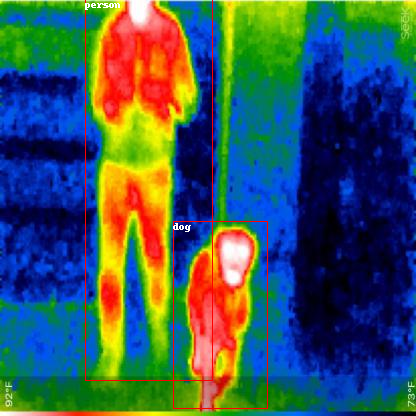

In [89]:
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image

In [ ]:
!zip -r test.zip /content/Thermal-Dogs-and-People-1/test

# FIN